<a href="https://colab.research.google.com/github/Ion-cells/model-training/blob/main/style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from google.colab import drive
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF


In [5]:
model = models.vgg19(pretrained= True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 60.3MB/s]


In [6]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [25]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features =  ['0','5','10','18','27']
        self.model = models.vgg19(pretrained= True).features[:27]
    def forward(self, x):
      features=[]

      for layer_num, layer in enumerate(self.model):
       x= layer(x)

       if str(layer_num) in self.chosen_features:
        features.append(x)
      return features

In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [14]:
# Load content and style images
original_img = load_image("/content/drive/MyDrive/Colab Notebooks/content.jpg")
style_img = load_image("/content/drive/MyDrive/Colab Notebooks/style.jpg")
generated = original_img.clone().requires_grad_(True)


In [ ]:

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 356

# Image preprocessing
loader = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor()
])

# Load image and move to device
def load_image(path):
    image = Image.open(path)
    image = loader(image).unsqueeze(0)
    return image.to(device)

# Display image in notebook
def show_tensor_image(tensor_img, title="Image"):
    img = tensor_img.clone().detach().cpu().squeeze(0)
    img = TF.to_pil_image(img.clamp(0, 1))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [26]:



# Custom VGG feature extractor
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ['0', '5', '10', '18', '27']
        self.model = models.vgg19(pretrained=True).features[:28]

    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features

# Model
model = VGG().to(device).eval()



Step [0/1000] Loss: 638124.3750


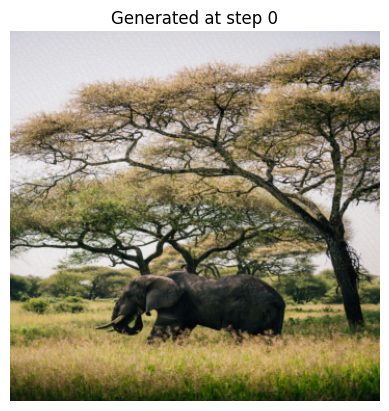

In [ ]:
 #Hyperparameters
total_steps = 1000
learning_rate = 0.01
alpha = 1
beta = 0.01
optimizer = optim.Adam([generated], lr=learning_rate)

# Training loop
for step in range(total_steps):
    generated_features = model(generated)
    original_features = model(original_img)
    style_features = model(style_img)

    style_loss = 0
    content_loss = 0

    for gen_feat, orig_feat, style_feat in zip(generated_features, original_features, style_features):
        _, c, h, w = gen_feat.shape

        # Content loss
        content_loss += torch.mean((gen_feat - orig_feat) ** 2)

        # Style loss via Gram matrix
        G = gen_feat.view(c, h * w) @ gen_feat.view(c, h * w).t()
        A = style_feat.view(c, h * w) @ style_feat.view(c, h * w).t()
        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha * content_loss + beta * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(f"Step [{step}/{total_steps}] Loss: {total_loss.item():.4f}")
        save_path = f"/content/generated_{step}.png"
        save_image(generated.clamp(0, 1), save_path)

        # Show in notebook
        show_tensor_image(generated, title=f"Generated at step {step}")
